In [1]:
#papermill_description=imports

import json
import os
import logging
import sys
from io import StringIO

import geopandas as gpd

import rasterio
import requests
import rioxarray
import xarray as xr

import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=parameters

local=True
map_results = True

notebook_key = "localjupyter"
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}
propertyName = "test"
output_type = "overlay"
colormap = "viridis"

# new parameters to enable multiple SLGA attributes to be fetched
slga_layer = "Organic_Carbon"
slga_layer_depth = "0-5cm"

In [3]:
#papermill_description=process_variables

output_tiff_directory = f"/tmp/{notebook_key}"
if local:
    output_tiff_directory = "/workspace/notebooks/sandbox/data/slga_testing"

# Ensure the storage directory exists
os.makedirs(output_tiff_directory, exist_ok=True)

In [4]:
#papermill_description=processing_file_io

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

In [5]:
#papermill_description=processing_bounding_box

geom = gdf.geometry #for data-harvester clip function

bounds = gdf.total_bounds

https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/30m/SOC/
https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/SOC/

In [6]:

# Define the COG URL
cog_url = "https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/30m/SOC/SOC_000_005_EV_N_P_AU_TRN_N_20220727_30m.tif"


In [7]:
# Open the COG file
with rasterio.open(cog_url) as src:
    gdf = gdf.to_crs(src.crs)
    bounds = gdf.total_bounds
    window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
    data = src.read(1, window=window)
    transform = src.window_transform(window)
    raster_crs = src.crs

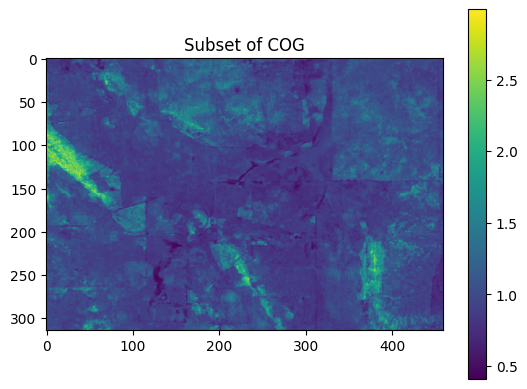

In [8]:
import matplotlib.pyplot as plt

# Plot the data
plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.title('Subset of COG')
plt.show()


In [9]:

raster_da = xr.DataArray(data, dims=("y", "x"))

raster_da = raster_da.rio.write_transform(transform)
raster_da = raster_da.rio.write_crs(raster_crs.to_string())

In [10]:
clipped_raster = raster_da.rio.clip(gdf.geometry, gdf.crs)

In [11]:
target_crs = "EPSG:4326"
reprojected_raster = clipped_raster.rio.reproject(target_crs)

In [12]:
output_cog_path = output_tiff_directory + "/SOC_test_cog.tif"
reprojected_raster.rio.to_raster(
    output_cog_path,
    compress="deflate",
    driver="COG"
)

/usr/local/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
